# Recurrent Neural Network(再帰型ニューラルネットワーク)

 - [EC購買サンプルデータセット](https://support.treasuredata.com/hc/ja/articles/213697057-%E3%82%B5%E3%83%B3%E3%83%97%E3%83%AB%E3%83%87%E3%83%BC%E3%82%BF%E3%82%BB%E3%83%83%E3%83%88-EC-)

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## RNN
### 時系列データ
 - 時系列データ : $x\left(1\right), \dots, x\left(t\right), \dots, x\left(T\right)$
     - ex) 電車の乗客数、自動車の動き、店舗の売り上げ、株価、為替...
 - RNNでは、$T$個の時系列データが１つの入力データ群となり、このデータ群を複数扱うことになる
     - 時系列データの並びに規則性・パターンがある(あるいはありそうに見える)データを学習することで、未知の時系列データが与えられたときに、そのデータの未来の状態を予測する

### 問題 : sin波の予測
$$
\begin{eqnarray}
f\left( t \right) & = & \sin {\left( \frac {2\pi}{T} t \right)} \quad (t=1,\dots,2T)
\end{eqnarray}
$$

 - $T$ : sin波の周期

<div style="text-align:center">
    <b>問題 : このsin波をニューラルネットワークで予測することができないか</b>
</div>

しかし、このままでは真の分布$f\left( t \right)$に従ったデータしか与えないことになってしまうので、下記のようにノイズ$u$を与えたsin波を考える。
$$
\begin{eqnarray}
f\left( t \right) & = & \sin {\left(\frac {2\pi}{T} t \right)} + 0.05u\\
u & \sim & U\left( -1.0, 1.0 \right)
\end{eqnarray}
$$

 - $U\left( a, b \right)$ : $a$から$b$までの一様分布
 
> sin波は、音を表している　→　「音波」
>
> - 規則性のある式(1) : 雑音のない綺麗な音を表している
> - ノイズの加わった式(2) : 雑音の混じった音を表している
>
> もしsin波をニューラルネットワークで学習できるのであれば、
> 1. それを応用することで音声認識・音声解析にも活用することが考えられる。
> 2. ノイズ入りのsin波から真の分布であるsin波を認識できれば、それはノイズの除去に相当する処理をニューラルネットワークによって実現できることにつながる。

**損失関数**:　二乗誤差
$$
E\left( \mathrm {\boldsymbol {w}} \right) = \frac {1}{2} \sum _{t=1}^{T}{\left[ \boldsymbol {t}\left(t\right) - \boldsymbol {y}\left(t ; \boldsymbol {\mathrm {w}} \right) \right]^{2}}
$$

 - $\boldsymbol {y}\left(t ; \boldsymbol {\mathrm {w}} \right)$ : モデルの出力(予測値)
 - $ \boldsymbol {t}\left(t\right)$ : 教師データ

**逆伝播**: BPTT法

### 実装 : 時系列データの生成

In [28]:
def sin(x, T=100):
    """sin関数"""
    return np.sin(2.0 * np.pi * x / T)

def toy_problem(T=100, ampl=0.05):
    """サイン波 + ノイズのデータを生成する"""
    x = np.arange(0, 2 * T + 1)
    noise = ampl * np.random.uniform(low=-1.0, high=1.0, size=len(x))
    return sin(x) + noise

/Users/taiyou/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['[IPAexGothic]'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


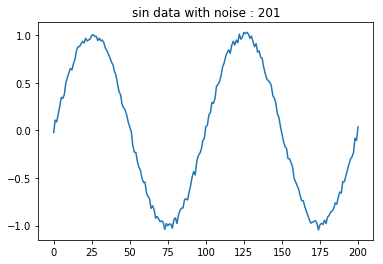

In [29]:
T = 100
f = toy_problem(T)

plt.title('sin data with noise : {0}'.format(f.size));
plt.plot(f)
plt.show()

### 実装 : 教師データへの整形

| 教師データ | 特徴ベクトル |
|:-------------:|:---------------:|
| $f\left( \tau + 1 \right)$ | $f\left( \tau \right), \dots, f\left( 1 \right)$ |
| $f\left( \tau + 2 \right)$ | $f\left( \tau + 1 \right), \dots, f\left( 2 \right)$ |
| $\vdots $ | $\vdots $ |
| $f\left( t + 1 \right)$ | $f\left( t \right), \dots, f\left( t - \tau + 1 \right)$ |

In [30]:
# τごとにデータを分割していく
length_of_sequences = 2 * T    # 全時系列の長さ
maxlen = 25    # 1つの時系列データの長さ

data = []
target = []

for i in range(0, length_of_sequences - maxlen + 1):
    data.append(f[i: i + maxlen])
    target.append(f[i + maxlen])

In [35]:
print(data[0])
print(target[0])

[-0.0230298   0.10741237  0.08945708  0.17150963  0.25199043  0.34657357
  0.33635162  0.37657686  0.50055346  0.55502585  0.60529002  0.64967511
  0.63519615  0.69955374  0.74749467  0.83796091  0.87870313  0.87972478
  0.9104736   0.93299022  0.91835464  0.96656311  0.93952608  0.94949945
  0.96091004]
0.9981846014545221


In [41]:
# 扱いやすい形状へ変更
X = np.array(data).reshape(len(data), maxlen, 1)
Y = np.array(target).reshape(len(data), 1)

In [42]:
print(X[0])
print(Y[0])

[[-0.0230298 ]
 [ 0.10741237]
 [ 0.08945708]
 [ 0.17150963]
 [ 0.25199043]
 [ 0.34657357]
 [ 0.33635162]
 [ 0.37657686]
 [ 0.50055346]
 [ 0.55502585]
 [ 0.60529002]
 [ 0.64967511]
 [ 0.63519615]
 [ 0.69955374]
 [ 0.74749467]
 [ 0.83796091]
 [ 0.87870313]
 [ 0.87972478]
 [ 0.9104736 ]
 [ 0.93299022]
 [ 0.91835464]
 [ 0.96656311]
 [ 0.93952608]
 [ 0.94949945]
 [ 0.96091004]]
[0.9981846]


In [43]:
from sklearn.model_selection import train_test_split


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0)

## TensorFlowによる実装

In [ ]:
def inference(x, maxlen):
    s = tanh(matmul(x, U) + matmul(s_prev, W) + b)
    for t in range(maxlen):
        s[t] = s[t - 1]
    y = matmul(s[t], V) + c
    return y

## Kerasによる実装

### モデルの設定

In [51]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import SimpleRNN
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


'''
モデル設定
'''
n_in = len(X[0][0])  # 1
n_hidden = 20
n_out = len(Y[0])  # 1


def weight_variable(shape, name=None):
    return np.random.normal(scale=0.01, size=shape)


early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

model = Sequential()
model.add(SimpleRNN(n_hidden,
                    kernel_initializer=weight_variable,
                    input_shape=(maxlen, n_in)))
model.add(Dense(n_out, kernel_initializer=weight_variable))
model.add(Activation('linear'))

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

model.compile(
    loss='mean_squared_error',
    optimizer=optimizer
)

/Users/taiyou/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/taiyou/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [53]:
'''
モデル学習
'''
epochs = 500
batch_size = 10

model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test, Y_test),
          callbacks=[early_stopping])

Train on 158 samples, validate on 18 samples
Epoch 1/500
158/158 [==============================] - 1s 4ms/step - loss: 0.4581 - val_loss: 0.5665
Epoch 2/500
158/158 [==============================] - 0s 771us/step - loss: 0.3552 - val_loss: 0.3834
Epoch 3/500
158/158 [==============================] - 0s 664us/step - loss: 0.2072 - val_loss: 0.1645
Epoch 4/500
158/158 [==============================] - 0s 667us/step - loss: 0.0901 - val_loss: 0.0775
Epoch 5/500
158/158 [==============================] - 0s 651us/step - loss: 0.0611 - val_loss: 0.0476
Epoch 6/500
158/158 [==============================] - 0s 638us/step - loss: 0.0458 - val_loss: 0.0370
Epoch 7/500
158/158 [==============================] - 0s 787us/step - loss: 0.0364 - val_loss: 0.0336
Epoch 8/500
158/158 [==============================] - 0s 664us/step - loss: 0.0314 - val_loss: 0.0359
Epoch 9/500
158/158 [==============================] - 0s 832us/step - loss: 0.0221 - val_loss: 0.0279
Epoch 10/500
158/158 [========

158/158 [==============================] - 0s 524us/step - loss: 0.0029 - val_loss: 0.0040
Epoch 80/500
158/158 [==============================] - 0s 603us/step - loss: 0.0023 - val_loss: 0.0020
Epoch 81/500
158/158 [==============================] - 0s 584us/step - loss: 0.0017 - val_loss: 0.0024
Epoch 82/500
158/158 [==============================] - 0s 718us/step - loss: 0.0018 - val_loss: 0.0018
Epoch 83/500
158/158 [==============================] - 0s 656us/step - loss: 0.0017 - val_loss: 0.0021
Epoch 84/500
158/158 [==============================] - 0s 622us/step - loss: 0.0018 - val_loss: 0.0018
Epoch 85/500
158/158 [==============================] - 0s 667us/step - loss: 0.0017 - val_loss: 0.0021
Epoch 86/500
158/158 [==============================] - 0s 628us/step - loss: 0.0017 - val_loss: 0.0017
Epoch 87/500
158/158 [==============================] - 0s 616us/step - loss: 0.0016 - val_loss: 0.0018
Epoch 88/500
158/158 [==============================] - 0s 664us/step - loss: